In [25]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctl
import numpy as np
import pandas as pd
import pyperclip

In [26]:
dt = 0.100
s  = ctl.TransferFunction.s

C = 0.394784176043574/(1.0*s**2 + 0.888576587631673*s + 0.394784176043574)
C

TransferFunction(array([0.39478418]), array([1.        , 0.88857659, 0.39478418]))

# TRANSFORMADA Z
Primeiro vamos aplicar a transformada $Z$ na planta com o método $zoh$ (que é adequado para a planta) e aplicar também uma outra transformada $z$ no controlador, com outro método de transformação mais adequado, para depois fechar a malha. As possíveis transformadas são:

- $zoh$ (zero-order hold on the inputs)
- $foh$ (linear interpolation of inputs)
- $tustin$ (bilinear approximation)
- $impulse$ (impulse-variant discretization)
- $matched$ (matched pole-zero method (for SISO systems only))

In [27]:
C_z = ctl.c2d(C, dt, method='tustin')
C_z

TransferFunction(array([0.00094408, 0.00188817, 0.00094408]), array([ 1.        , -1.91122623,  0.91500257]), 0.1)

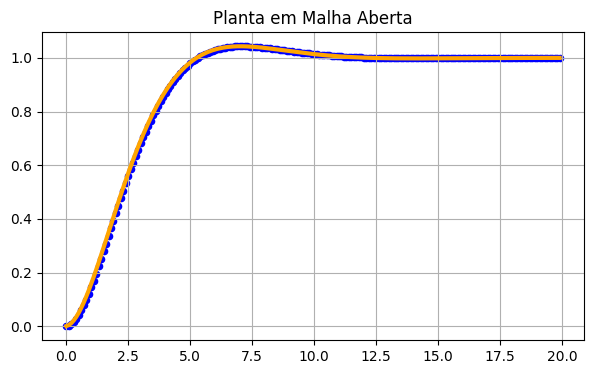

In [28]:
time = np.arange(0, 20, dt)
time, continuous = ctl.step_response(C, T=time)
time, digital    = ctl.step_response(C_z, T=time)

plt.figure(figsize=(7, 4))
plt.scatter(time, continuous, color='blue', s=20, label='tempo discreto')
plt.plot(time, digital, color='orange', linewidth=3, label='tempo contínuo')
plt.title('Planta em Malha Aberta')
plt.grid()

# DIGITALIZANDO O SISTEMA
- Preparando as funções que permitem digitalizar a função de transferência em transformada $Z$
    - **printDigital**: Passando os vetores dos coeficientes do numerador e denominador para uma string que é a própria função do sistema discretizada
    - **compute**: aplica a função digitalizada a partir dos estados anteriores

- Estados anteriores
    - Y[0], Y[1], Y[2] ... se referem aos estados $Y_n$ (saída atual), $Y_{n-1}$ (penúltima saída), $Y_{n-2}$ (antipenúltima saída)

In [29]:
def getFraction(G_z):
    num, den = ctl.tfdata(G_z)
    num = np.squeeze(num)
    den = np.squeeze(den)

    num = num/den[0]
    den = den/den[0]

    if type(num) == np.float64:
        num = np.array([num])

    num = [float(val) for val in num]
    den = [float(val) for val in den]
    return (num, den) 


num, den = getFraction(C_z)
print(f'num -> xSize={len(num)}')
print(f'den -> ySize={len(den)}')

num -> xSize=3
den -> ySize=3


In [30]:
def printDigital(num, den):
    out = ''
    
    for i in range(0, len(num)): 
        out += f'Xn{i}*({num[i]:.6f}) + '

    for i in range(1, len(den)): 
        out += f'Yn{i}*({-1*den[i]:.6f}) + '
    
    out = out.replace('Xn0', 'Xn')[:-3] + ';'
    pyperclip.copy(out)
    print(out)


printDigital(num, den)

Xn*(0.000944) + Xn1*(0.001888) + Xn2*(0.000944) + Yn1*(1.911226) + Yn2*(-0.915003);


# OBJETO SISTEMA

In [31]:
class StatesUpdater:
    buffer  = None
    initial = 0
    size    = 0

    def __init__(self, size, initial=0):
        self.initial = initial
        self.size    = size
        self.buffer  = initial * np.ones(size)
        
    def update(self, value=None):
        for i in range(self.size-1, 0, -1):
            self.buffer[i] = self.buffer[i-1]
        
        self.setFirst(value)
        return self.buffer
    
    def setFirst(self, value):
        if value is not None:
            self.buffer[0] = value

    def reset(self):
        for i in range(self.size): self.buffer[i] = self.initial
    

states = StatesUpdater(3)
for i in range(1, 5): print(states.update(i))

[1. 0. 0.]
[2. 1. 0.]
[3. 2. 1.]
[4. 3. 2.]


In [32]:
class DigitalSystem:
    def __init__(self, num, den, dt=0.05, bounds=None):
        self.bounds = bounds if bounds is not None else (-9e12, 9e12)
        self.num = num
        self.den = den
        self.dt  = dt
        self.Xn  = StatesUpdater(size=len(num))
        self.Yn  = StatesUpdater(size=len(den))

    def compute(self):
        out = 0.0
        
        for i in range(0, self.Xn.size): 
            out += self.Xn.buffer[i]*(self.num[i])
        
        for i in range(1, self.Yn.size):
            out += self.Yn.buffer[i]*(-1*self.den[i])
        
        if out > self.bounds[1]:
            out = self.bounds[1]
        
        if out < self.bounds[0]:
            out = self.bounds[0]
        
        return out

    def update(self, input):
        self.Xn.update(input)
        self.Yn.update()

        output = self.compute()
        self.Yn.setFirst(output)
        return output
    
    def control(self, input, setpoint):
        return self.update(setpoint - input)
    
    def reset(self):
        self.Xn.reset(), self.Yn.reset()
    

filter = DigitalSystem(num, den, dt)

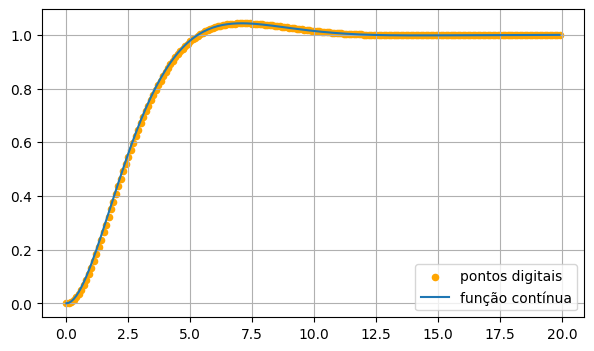

In [33]:
time    = np.arange(0, 20, dt)
digital = [0.0] + [filter.update(1) for k in range(1, len(time))]
time, continuous = ctl.step_response(C, T=time)

plt.figure(figsize=(7, 4))
plt.scatter(time, digital, label='pontos digitais', color='orange', s=20)
plt.plot(time, continuous, label='função contínua')
plt.grid(), plt.legend()
plt.show()

# SIMULANDO SISTEMA

In [34]:
df = pd.read_csv('DataBase.csv')
df.head()

,time,input
0,110.062839,4034.0
1,110.141765,4045.0
2,110.221532,4059.0
3,110.301835,4044.0
4,110.382143,4043.0


In [35]:
def normalizeTable(df, key, dt=0.15):
    df[key]  = df[key] - df[key][0] # INICIA NO TEMPO 0
    initTime = df[key].iloc[0]
    finalTime = df[key].iloc[-1] + dt
    newAxis = np.arange(initTime, finalTime, dt)
    df = df.set_index(key).reindex(newAxis, method='ffill')
    return df.reset_index().rename(columns={'index': key})


df = normalizeTable(df, 'time', dt)
df

,time,input
0,0.0,4034.0
1,0.1,4045.0
2,0.2,4059.0
3,0.3,4044.0
4,0.4,4043.0
...,...,...
1395,139.5,4095.0
1396,139.6,4095.0
1397,139.7,4095.0
1398,139.8,4095.0


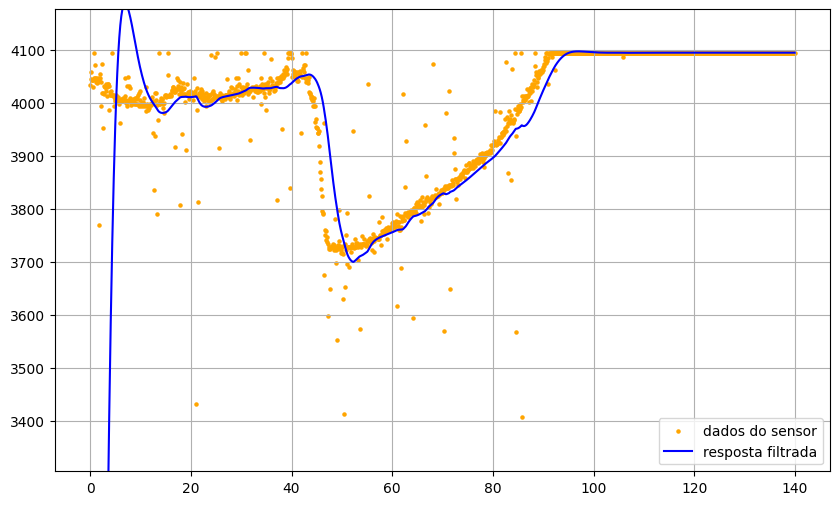

In [36]:
xData  = df.time.values
yData  = df.input.values
yModel = [filter.update(val) for val in yData]

plt.figure(figsize=(10, 6))
plt.scatter(xData, yData, s=5, color='orange', label='dados do sensor')
plt.plot(xData, yModel, color='blue', label='resposta filtrada')
plt.ylim(yData.min()*0.97, yData.max()*1.02)
plt.legend(), plt.grid()
plt.show()